Importing Libraries

In [1]:
import pandas as pd
import numpy as np
from math import isclose
import matplotlib.pyplot as plt
import random as rd

from xgboost.sklearn import XGBClassifier

from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.compose import make_column_selector as selector
from sklearn.compose import make_column_transformer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.feature_selection import RFECV
from sklearn.model_selection import GridSearchCV

from imblearn.under_sampling import CondensedNearestNeighbour, RandomUnderSampler

Importing raw data

In [2]:
dir = 'C:/Users/GEOFF/OneDrive/Documents/Apziva/Term_Deposit_Marketing/'
path = dir+'data/raw/'
dataframe = pd.read_csv(path+"term-deposit-marketing-2020.csv")
target_name = 'y'
target = dataframe[target_name]
data = dataframe.drop(columns = [target_name])

numerical_columns_selector = selector(dtype_exclude=object)
categorical_columns_selector = selector(dtype_include=object)

numerical_columns = numerical_columns_selector(data)
categorical_columns = categorical_columns_selector(data)

print('There are %s costumer datapoints'%len(data))
print('\nThere are %s features, which are:'%len(data.columns))
print(set(data.columns))

print('\nThe numerical features are:')
print(numerical_columns)

print('\nThe categorical features are:')
print(categorical_columns)

print('\nThe 5 first customers data are:')
print(data.head())

There are 40000 costumer datapoints

There are 13 features, which are:
{'default', 'day', 'job', 'marital', 'loan', 'age', 'housing', 'balance', 'duration', 'month', 'contact', 'campaign', 'education'}

The numerical features are:
['age', 'balance', 'day', 'duration', 'campaign']

The categorical features are:
['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month']

The 5 first customers data are:
   age           job  marital  education default  balance housing loan  \
0   58    management  married   tertiary      no     2143     yes   no   
1   44    technician   single  secondary      no       29     yes   no   
2   33  entrepreneur  married  secondary      no        2     yes  yes   
3   47   blue-collar  married    unknown      no     1506     yes   no   
4   33       unknown   single    unknown      no        1      no   no   

   contact  day month  duration  campaign  
0  unknown    5   may       261         1  
1  unknown    5   may       151         

Discriminating the heterogeneous features

In [3]:
print('\nDescription of the numerical features in the data:')
print(data.describe())
non_binary_categorical_columns = {}
binary_categorical_columns = []
for category in categorical_columns:
    nb_cat = pd.Series.nunique(data[category])
    if nb_cat > 2:
        non_binary_categorical_columns[category] = f' ({nb_cat} values found)'
    else:
        binary_categorical_columns.append(category)

print('\nThe binary categorical columns are:')
for cat in binary_categorical_columns:
    print(cat, ' (2 values found)')
print('\nThe other categorical columns are:')
for key, value in non_binary_categorical_columns.items():
    print(key, value)
non_binary_categorical_columns = list(non_binary_categorical_columns.keys())


Description of the numerical features in the data:
                age        balance           day      duration      campaign
count  40000.000000   40000.000000  40000.000000  40000.000000  40000.000000
mean      40.544600    1274.277550     16.017225    254.824300      2.882175
std        9.641776    2903.769716      8.278127    259.366498      3.239051
min       19.000000   -8019.000000      1.000000      0.000000      1.000000
25%       33.000000      54.000000      8.000000    100.000000      1.000000
50%       39.000000     407.000000     17.000000    175.000000      2.000000
75%       48.000000    1319.000000     21.000000    313.000000      3.000000
max       95.000000  102127.000000     31.000000   4918.000000     63.000000

The binary categorical columns are:
default  (2 values found)
housing  (2 values found)
loan  (2 values found)

The other categorical columns are:
job  (12 values found)
marital  (3 values found)
education  (4 values found)
contact  (3 values found)
mont

Encoding the categorical features and scaling the numerical features

In [4]:
ColumnTransformer_ = make_column_transformer(
    (StandardScaler(), numerical_columns),
    (OneHotEncoder(), categorical_columns),
    remainder='passthrough',
    n_jobs = 4)

Transformed_Columns = ColumnTransformer_.fit_transform(data)
columns = ColumnTransformer_.get_feature_names_out()
print(f'The transformed features names are\n{columns}\n')
transformed_df = pd.DataFrame(Transformed_Columns.toarray(), columns = columns)

# Dropping the "no" columns resulting from the one-hot encoding of binary categorical features
columns_to_drop = []
for feature in binary_categorical_columns:
    columns_to_drop.append('onehotencoder__'+feature+'_no')
transformed_df.drop(columns = columns_to_drop, inplace = True)

print(f'The transformed dataset has a shape of {transformed_df.shape}')
print(f'A total of {len(columns)-transformed_df.shape[1]} useless encoded features were removed')

transformed_target = LabelEncoder().fit_transform(target)

The transformed features names are
['standardscaler__age' 'standardscaler__balance' 'standardscaler__day'
 'standardscaler__duration' 'standardscaler__campaign'
 'onehotencoder__job_admin' 'onehotencoder__job_blue-collar'
 'onehotencoder__job_entrepreneur' 'onehotencoder__job_housemaid'
 'onehotencoder__job_management' 'onehotencoder__job_retired'
 'onehotencoder__job_self-employed' 'onehotencoder__job_services'
 'onehotencoder__job_student' 'onehotencoder__job_technician'
 'onehotencoder__job_unemployed' 'onehotencoder__job_unknown'
 'onehotencoder__marital_divorced' 'onehotencoder__marital_married'
 'onehotencoder__marital_single' 'onehotencoder__education_primary'
 'onehotencoder__education_secondary' 'onehotencoder__education_tertiary'
 'onehotencoder__education_unknown' 'onehotencoder__default_no'
 'onehotencoder__default_yes' 'onehotencoder__housing_no'
 'onehotencoder__housing_yes' 'onehotencoder__loan_no'
 'onehotencoder__loan_yes' 'onehotencoder__contact_cellular'
 'onehotenco

Undersampling the data to obtain balance regarding to the target

In [5]:
print('The data is unbalanced')
print(f'The proportion of the minority class is {sum(transformed_target)/transformed_target.shape[0]:.2f}\n')

# undersample = CondensedNearestNeighbour(n_neighbors=1)
undersample = RandomUnderSampler(random_state=42)
X, y = undersample.fit_resample(transformed_df, transformed_target)

print('The dataset resulting from undersampling has a shape of', X.shape, 
      '\nThe label array resulting from undersampling has a shape of', y.shape)
print(f'The proportion of the minority class is now {sum(y)/y.shape[0]:.2f}\n')

data_train, data_test, target_train, target_test = train_test_split(
    np.array(X), y, test_size = 0.2, stratify = y, random_state=42)

print('The data resulting from undersampling is now divided into a train and a test set 80/20%')
print('The train set and label array have a shape of ', data_train.shape, target_train.shape)
print('The test set and label array have a shape of ', data_test.shape, target_test.shape)

The data is unbalanced
The proportion of the minority class is 0.07

The dataset resulting from undersampling has a shape of (5792, 41) 
The label array resulting from undersampling has a shape of (5792,)
The proportion of the minority class is now 0.50

The data resulting from undersampling is now divided into a train and a test set 80/20%
The train set and label array have a shape of  (4633, 41) (4633,)
The test set and label array have a shape of  (1159, 41) (1159,)


Trying a Decision Tree model with a depth of 1 to detect the most informative feature

The mean cross-validation training accuracy is: 0.792 ± 0.002
The mean cross-validation accuracy is: 0.792 ± 0.008

The feature that yields the most information gain is standardscaler__duration
The average call duration is 254 sec
 The standard deviation is 259 sec
The call duration threshold is 376 sec
The mean cross-validation accuracy was 0.792 just from using that criteria


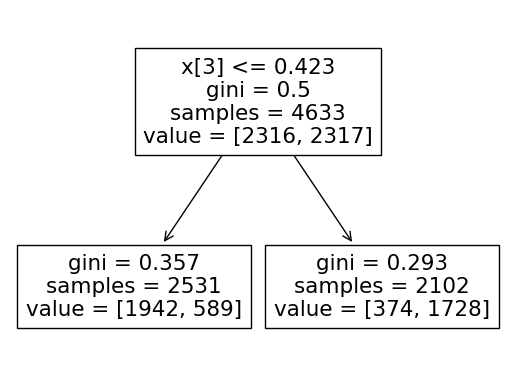

In [6]:
simple_tree_model = DecisionTreeClassifier(max_depth = 1,
                                    max_leaf_nodes = 2,
                                    max_features = None,
                                    random_state = 42)

simple_tree_cv_results = cross_validate(simple_tree_model, data_train, target_train, cv=5, 
                                        return_train_score = True)

t_scores = simple_tree_cv_results["train_score"]
print("The mean cross-validation training accuracy is: "
      f"{t_scores.mean():.3f} ± {t_scores.std():.3f}")
scores = simple_tree_cv_results["test_score"]
print("The mean cross-validation accuracy is: "
      f"{scores.mean():.3f} ± {scores.std():.3f}")

simple_tree_model.fit(data_train, target_train)
plot_tree(simple_tree_model)

print(f'\nThe feature that yields the most information gain is {columns[3]}')

this_transformed_column = transformed_df[columns[3]]
this_column = np.array(dataframe['duration'])
scaler = StandardScaler()
this_retransformed_column = scaler.fit_transform(this_column.reshape(-1,1))
print(f'The average call duration is {int(scaler.mean_)} sec\n',
      f'The standard deviation is {int(scaler.var_**0.5)} sec')

threshold = scaler.inverse_transform(np.array([0.469]*40000).reshape(-1,1))
print(f'The call duration threshold is {threshold[0,0]:.0f} sec')
print(f'The mean cross-validation accuracy was {scores.mean():.3f} just from using that criteria')

# Checking if the scaler StandardScaler fitted the column with the same parameters as ColumnTranformer did
equal = np.array([isclose(this_retransformed_column[i], this_transformed_column[i], abs_tol = 1e-6) for i in range(40000)])
assert equal.all()

Trying a Logistic Regression model (works)

In [7]:
logis_model = LogisticRegression(penalty = 'l2',
                                 C = 1.0,
                                 solver = 'newton-cholesky', # sag and saga solvers can be tried as well
                                 max_iter = 100,
                                 n_jobs = 4)

logis_cv_results = cross_validate(logis_model, data_train, target_train, cv=5, 
                                  return_train_score = True)

t_scores = logis_cv_results["train_score"]
print("The mean cross-validation training accuracy is: "
      f"{t_scores.mean():.3f} ± {t_scores.std():.3f}")
scores = logis_cv_results["test_score"]
print("The mean cross-validation accuracy is: "
      f"{scores.mean():.3f} ± {scores.std():.3f}")

The mean cross-validation training accuracy is: 0.857 ± 0.002
The mean cross-validation accuracy is: 0.852 ± 0.008


Trying a shallow Decision Tree model (works)

The mean cross-validation training accuracy is: 0.838 ± 0.002
The mean cross-validation accuracy is: 0.837 ± 0.015
The selected features in this tree were:
['standardscaler__duration', 'onehotencoder__month_apr', 'onehotencoder__month_mar', 'onehotencoder__housing_yes', 'onehotencoder__contact_unknown']
From the decision tree, for clients with a call duration below the threshold
if the last call was in April and if the client has no housing loan, or if last call was in March
y is more likely to be 1


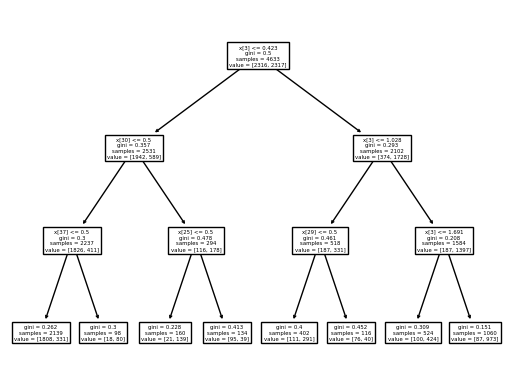

In [8]:
tree_model = DecisionTreeClassifier(max_depth = 3,
                                    max_leaf_nodes = 20,
                                    max_features = None,
                                    random_state = 42)

tree_cv_results = cross_validate(tree_model, data_train, target_train, cv=5, 
                                  return_train_score = True)

t_scores = tree_cv_results["train_score"]
print("The mean cross-validation training accuracy is: "
      f"{t_scores.mean():.3f} ± {t_scores.std():.3f}")
scores = tree_cv_results["test_score"]
print("The mean cross-validation accuracy is: "
      f"{scores.mean():.3f} ± {scores.std():.3f}")
tree_model.fit(data_train, target_train)
plot_tree(tree_model)
print(f'The selected features in this tree were:\n{list(transformed_df.iloc[:,[3,30,37,25,29]].columns)}')
print('From the decision tree, for clients with a call duration below the threshold\n' 
       'if the last call was in April and if the client has no housing loan, or if last call was in March\n'
        'y is more likely to be 1')

Trying a XGBoost model

In [9]:
model = XGBClassifier(random_state=42)
parameters = {'n_estimators':list(range(1,501,100)), 
              'max_depth':list(range(1,11,1)), 
              'learning_rate':[round(10**(i/10),3) for i in range(-20, 0, 5)]}
clf = GridSearchCV(estimator = model, param_grid = parameters, cv = 5, return_train_score = True)
clf.fit(data_train, target_train)
print('The best parameters in the specified grid are found to be\n', clf.best_params_)
print(f"Mean training accuracy: {clf.cv_results_['mean_train_score'][clf.best_index_]:0.3f}")
print(f'Cross-validation accuracy: {clf.best_score_:0.3f}')

The best parameters in the specified grid are found to be
 {'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 201}
Mean training accuracy: 0.924
Cross-validation accuracy: 0.881


In [10]:
best_params = {'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 200}

Trying the XGBoost model with above found parameters

In [11]:
n_estimators = best_params['n_estimators']
max_depth = best_params['max_depth']
learning_rate = best_params['learning_rate']

model = XGBClassifier(n_estimators = n_estimators, 
                             max_depth = max_depth, 
                             learning_rate = learning_rate, 
                             random_state = 42)

cv_results = cross_validate(model, data_train, target_train, cv=5,
                            return_train_score = True)

t_scores = cv_results["train_score"]
print("The mean training accuracy is: "
      f"{t_scores.mean():.3f} ± {t_scores.std():.3f}")
scores = cv_results["test_score"]
print("The mean cross-validation accuracy is: "
      f"{scores.mean():.3f} ± {scores.std():.3f}")

The mean training accuracy is: 0.923 ± 0.003
The mean cross-validation accuracy is: 0.881 ± 0.002


Overfitting test with max_depth variable

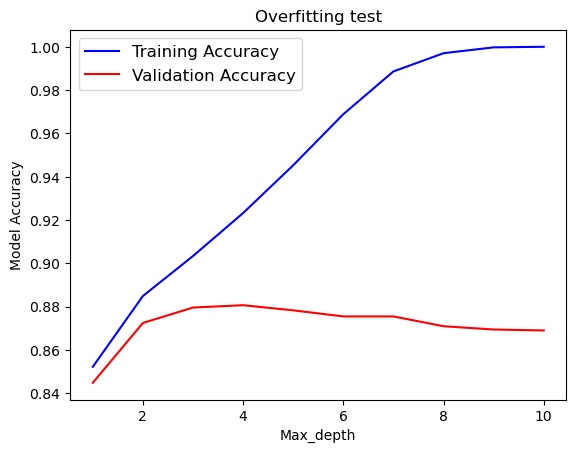

In [12]:
training_accuracies = []
validation_accuracies = []
for max_depth in range(1,11):
    model = XGBClassifier(n_estimators = n_estimators, 
                                 max_depth = max_depth, 
                                 learning_rate = learning_rate, 
                                 random_state = 42)

    cv_results = cross_validate(model, data_train, target_train, cv=5,
                                return_train_score = True)

    t_scores = cv_results["train_score"]
    training_accuracies.append(t_scores.mean())
    scores = cv_results["test_score"]
    validation_accuracies.append(scores.mean())
fig, ax = plt.subplots(1,1)
ax.plot(list(range(1,11)), training_accuracies, color = 'blue', label = 'Training Accuracy')
ax.plot(list(range(1,11)), validation_accuracies, color = 'red', label = 'Validation Accuracy')
ax.legend(fontsize = 12)
ax.set_xlabel('Max_depth')
ax.set_ylabel('Model Accuracy')
ax.set_title('Overfitting test')
plt.show()

The cross-validation accuracy results will be displayed in detail for each run

In [13]:
best_params = {'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 200}
n_estimators = best_params['n_estimators']
max_depth = best_params['max_depth']
learning_rate = best_params['learning_rate']

model = XGBClassifier(n_estimators = n_estimators, 
                             max_depth = max_depth, 
                             learning_rate = learning_rate, 
                             random_state = 42)

In [14]:
def Kfold_crossvalidation(partition):
    accuracy = 0
    n = 0
    for train, test in partition:
        model.fit(data_train[train], target_train[train])
        target_train_predict = model.predict(data_train[test])
        accuracy += model.score(data_train[test], target_train[test])
        n += 1
        print(classification_report(target_train[test], target_train_predict))
    accuracy *= 1/n
    print(f'cross validation accuracy = {accuracy}')

skf = StratifiedKFold(5, shuffle = False)
Kfold_crossvalidation(skf.split(data_train, target_train))

              precision    recall  f1-score   support

           0       0.92      0.84      0.87       464
           1       0.85      0.92      0.89       463

    accuracy                           0.88       927
   macro avg       0.88      0.88      0.88       927
weighted avg       0.88      0.88      0.88       927

              precision    recall  f1-score   support

           0       0.91      0.85      0.88       463
           1       0.86      0.92      0.89       464

    accuracy                           0.88       927
   macro avg       0.88      0.88      0.88       927
weighted avg       0.88      0.88      0.88       927

              precision    recall  f1-score   support

           0       0.90      0.84      0.87       463
           1       0.85      0.91      0.88       464

    accuracy                           0.88       927
   macro avg       0.88      0.88      0.88       927
weighted avg       0.88      0.88      0.88       927

              preci

In [15]:
logis_model.fit(data_train, target_train)
target_test_predict = logis_model.predict(data_test)
print('\nFor the Logistic Regression model, the test results are:\n')
print(classification_report(target_test, target_test_predict))

tree_model.fit(data_train, target_train)
target_test_predict = tree_model.predict(data_test)
print('For the Decision Tree model, the test results are:\n')
print(classification_report(target_test, target_test_predict))

model.fit(data_train, target_train)
target_test_predict = model.predict(data_test)
print('For the XGBoost model, the test results are:\n')
print(classification_report(target_test, target_test_predict))


For the Logistic Regression model, the test results are:

              precision    recall  f1-score   support

           0       0.89      0.87      0.88       580
           1       0.87      0.89      0.88       579

    accuracy                           0.88      1159
   macro avg       0.88      0.88      0.88      1159
weighted avg       0.88      0.88      0.88      1159

For the Decision Tree model, the test results are:

              precision    recall  f1-score   support

           0       0.83      0.84      0.83       580
           1       0.84      0.83      0.83       579

    accuracy                           0.83      1159
   macro avg       0.83      0.83      0.83      1159
weighted avg       0.83      0.83      0.83      1159

For the XGBoost model, the test results are:

              precision    recall  f1-score   support

           0       0.93      0.84      0.88       580
           1       0.86      0.93      0.89       579

    accuracy             